## Load data

In [1]:
import os
os.chdir('..')

In [2]:
from src.dataset import *
from src.model import *
from src.train_test import *
import matplotlib.pyplot as plt
import pandas as pd
from torch import optim
from src.vis import *
from src.gradient import *

In [3]:
batch_size = 32
model_name = 'CIFAR17'
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [4]:
# load data
train_data_loader = data_loader(dataset_name = 'CIFAR10', 
                                batch_size = batch_size, 
                                train=True)
test_data_loader = data_loader(dataset_name = 'CIFAR10', 
                                batch_size = batch_size, 
                                train=False)    


Files already downloaded and verified
Files already downloaded and verified


## Original model

In [5]:
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

In [6]:
plot_training_acc(model, train_data_loader,
                  model_name=model_name, data_name='CIFAR10', total_trails=30)

  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  0%|          | 5/1563 [00:00<00:32, 47.68it/s]

Test set: Average loss: 0.8211, Accuracy: 35700/50000 (71%)

Trail 2


  1%|          | 9/1563 [00:00<00:19, 81.07it/s]

Test set: Average loss: 0.8266, Accuracy: 35509/50000 (71%)

Trail 3


  1%|          | 8/1563 [00:00<00:21, 73.07it/s]

Test set: Average loss: 0.8477, Accuracy: 35142/50000 (70%)

Trail 4


  0%|          | 5/1563 [00:00<00:33, 45.87it/s]

Test set: Average loss: 0.8119, Accuracy: 35776/50000 (72%)

Trail 5


100%|██████████| 1563/1563 [00:23<00:00, 67.11it/s] 


Test set: Average loss: 0.8619, Accuracy: 34810/50000 (70%)



  0%|          | 6/1563 [00:00<00:28, 54.12it/s]

Trail 6


100%|██████████| 1563/1563 [00:17<00:00, 87.93it/s] 


Test set: Average loss: 0.8297, Accuracy: 35361/50000 (71%)



  0%|          | 5/1563 [00:00<00:40, 38.36it/s]

Trail 7


  0%|          | 4/1563 [00:00<00:45, 33.97it/s]

Test set: Average loss: 0.8539, Accuracy: 35084/50000 (70%)

Trail 8


  1%|          | 8/1563 [00:00<00:21, 73.64it/s]

Test set: Average loss: 0.7805, Accuracy: 36359/50000 (73%)

Trail 9


100%|██████████| 1563/1563 [00:18<00:00, 86.67it/s] 


Test set: Average loss: 0.8107, Accuracy: 35883/50000 (72%)



  0%|          | 5/1563 [00:00<00:37, 41.61it/s]

Trail 10


100%|██████████| 1563/1563 [00:17<00:00, 91.60it/s] 


Test set: Average loss: 0.8277, Accuracy: 35474/50000 (71%)



  0%|          | 6/1563 [00:00<00:27, 57.25it/s]

Trail 11


  0%|          | 7/1563 [00:00<00:22, 69.20it/s]

Test set: Average loss: 0.8190, Accuracy: 35625/50000 (71%)

Trail 12


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.8868, Accuracy: 34380/50000 (69%)

Trail 13


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.8806, Accuracy: 34455/50000 (69%)

Trail 14


  1%|          | 8/1563 [00:00<00:21, 72.20it/s]

Test set: Average loss: 0.8145, Accuracy: 35717/50000 (71%)

Trail 15


  0%|          | 5/1563 [00:00<00:32, 48.39it/s]

Test set: Average loss: 0.7816, Accuracy: 36160/50000 (72%)

Trail 16


  0%|          | 7/1563 [00:00<00:22, 68.41it/s]

Test set: Average loss: 0.7854, Accuracy: 36211/50000 (72%)

Trail 17


  1%|          | 8/1563 [00:00<00:21, 71.81it/s]

Test set: Average loss: 0.8026, Accuracy: 35957/50000 (72%)

Trail 18


100%|██████████| 1563/1563 [00:21<00:00, 73.80it/s] 


Test set: Average loss: 0.8222, Accuracy: 35467/50000 (71%)



  0%|          | 4/1563 [00:00<00:49, 31.63it/s]

Trail 19


 57%|█████▋    | 891/1563 [00:12<00:09, 68.80it/s]


KeyboardInterrupt: 

### Get correct predicted training data index for each model

In [81]:
# 
correct_index_list = dict()
for trail in range(1, 31):
    correct_index_list[str(trail)] = [] # initialize
    
    checkpoint = 'checkpoints/CIFAR17-CIFAR10-model{}/999.pt'.format(trail)
    model.load_state_dict(torch.load(checkpoint))
    print('Trail {}'.format(str(trail)))
    correct_index = test_correct(model, train_data_loader)
    correct_index_list[str(trail)] = correct_index


  1%|          | 15/1563 [00:00<00:10, 146.45it/s]

Trail 1


  1%|          | 18/1563 [00:00<00:08, 173.81it/s]

Trail 2


  1%|          | 18/1563 [00:00<00:08, 177.06it/s]

Trail 3


  1%|          | 18/1563 [00:00<00:08, 172.11it/s]

Trail 4


  1%|          | 18/1563 [00:00<00:08, 175.22it/s]

Trail 5


  1%|          | 18/1563 [00:00<00:08, 171.91it/s]

Trail 6


  1%|          | 18/1563 [00:00<00:08, 175.03it/s]

Trail 7


  1%|          | 18/1563 [00:00<00:08, 175.30it/s]

Trail 8


  1%|          | 18/1563 [00:00<00:08, 175.95it/s]

Trail 9


  1%|          | 18/1563 [00:00<00:08, 175.21it/s]

Trail 10


  1%|          | 18/1563 [00:00<00:09, 170.64it/s]

Trail 11


  1%|          | 18/1563 [00:00<00:08, 176.88it/s]

Trail 12


  1%|          | 18/1563 [00:00<00:08, 175.40it/s]

Trail 13


  1%|          | 18/1563 [00:00<00:08, 175.46it/s]

Trail 14


  1%|          | 18/1563 [00:00<00:08, 173.58it/s]

Trail 15


  1%|          | 18/1563 [00:00<00:08, 174.25it/s]

Trail 16


  1%|          | 18/1563 [00:00<00:08, 176.68it/s]

Trail 17


  1%|          | 18/1563 [00:00<00:08, 172.74it/s]

Trail 18


  1%|          | 18/1563 [00:00<00:08, 172.54it/s]

Trail 19


  1%|          | 18/1563 [00:00<00:08, 174.73it/s]

Trail 20


  1%|          | 16/1563 [00:00<00:10, 152.33it/s]

Trail 21


  1%|          | 18/1563 [00:00<00:08, 176.16it/s]

Trail 22


  1%|          | 18/1563 [00:00<00:08, 174.65it/s]

Trail 23


  1%|          | 18/1563 [00:00<00:08, 172.77it/s]

Trail 24


  1%|          | 15/1563 [00:00<00:10, 144.32it/s]

Trail 25


  1%|          | 18/1563 [00:00<00:08, 173.45it/s]

Trail 26


  1%|          | 18/1563 [00:00<00:09, 170.67it/s]

Trail 27


  1%|          | 18/1563 [00:00<00:08, 176.07it/s]

Trail 28


  1%|          | 18/1563 [00:00<00:08, 175.24it/s]

Trail 29


  1%|          | 18/1563 [00:00<00:08, 176.50it/s]

Trail 30


100%|██████████| 1563/1563 [00:08<00:00, 175.24it/s]


### Plot histogram of number of times that a model correctly predict it out of 30 models in total 

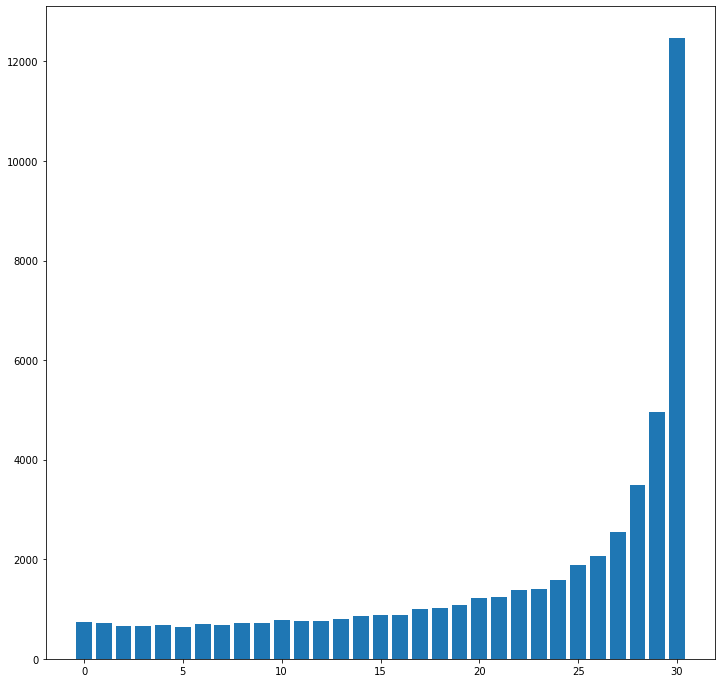

In [82]:
# 
df = pd.DataFrame.from_dict(correct_index_list)
correct_times = list(df.agg("sum", axis="columns"))

plt.bar(range(0, 31), [np.sum(np.asarray(correct_times)==i) for i in range(0, 31)])
plt.show()

### Record positive samples (>=25 times correct) and negative sample (<=5 times correct)

In [83]:
pos_index = np.where(np.asarray(correct_times) >= 25)[0]
neg_index = np.where(np.asarray(correct_times) <= 5)[0]

np.save('datasets/CIFAR_train_pos_index', pos_index)
np.save('datasets/CIFAR_train_neg_index', neg_index)

In [8]:
# create loader for positive samples and negative samples
pos_index = np.load('datasets/CIFAR_train_pos_index.npy')
neg_index = np.load('datasets/CIFAR_train_neg_index.npy')

train_data_loader_pos = data_loader(batch_size=1,  # batch size must be 1
                                    dataset_name = 'CIFAR10', 
                                    subsample_id=pos_index.tolist(), 
                                    train=True,
                                    shuffle=False) # shuffle should be disabled

train_data_loader_neg = data_loader(batch_size=1, 
                                    dataset_name = 'CIFAR10', 
                                    subsample_id=neg_index.tolist(), 
                                    train=True,
                                    shuffle=False) # shuffle should be disabled

Files already downloaded and verified
Files already downloaded and verified


In [9]:
print(len(pos_index))
print(len(neg_index))
print(len(train_data_loader_pos))
print(len(train_data_loader_neg))

27440
4105
27440
4105


### Gradient computation for pos and neg 

In [10]:
# get average gradient for pos samples and neg samples
trail = 1
checkpoint = 'checkpoints/CIFAR17-CIFAR10-model{}/999.pt'.format(trail)
model.load_state_dict(torch.load(checkpoint))
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
print('Trail {}'.format(str(trail)))

pos_grad_dict = record_grad(model, train_data_loader_pos, 
                            criterion=nn.CrossEntropyLoss(reduction='sum'), 
                            optimizer=optimizer) # should use reduction method to be sum

 
    
neg_grad_dict = record_grad(model, train_data_loader_neg, 
                            criterion=nn.CrossEntropyLoss(reduction='sum'), 
                            optimizer=optimizer)


  0%|          | 17/27440 [00:00<02:48, 162.91it/s]

Trail 1
Length of dataloader 27440


  1%|          | 23/4105 [00:00<00:18, 226.52it/s]

Length of dataloader 4105


100%|██████████| 4105/4105 [00:17<00:00, 229.79it/s]


### Weights contradiction visualization

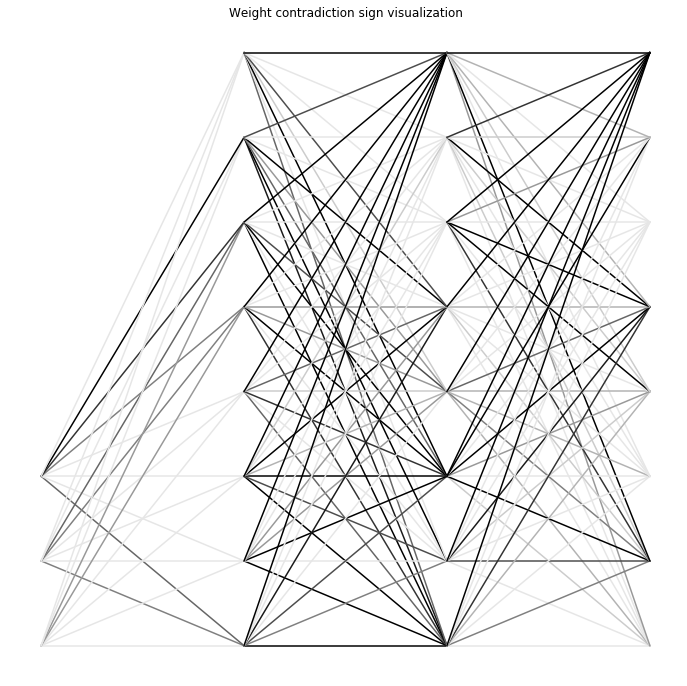

tensor([[0.0000, 1.0607, 1.2842],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.7810, 1.0649, 1.1096],
        [0.2304, 0.4839, 0.7381],
        [0.0000, 0.0000, 3.3260],
        [0.0000, 0.0000, 0.0000]])
tensor([[0.6307, 0.4644, 0.7777, 0.3678, 0.4746, 0.4085, 0.5187, 0.3153],
        [0.2559, 0.0000, 0.3403, 0.0000, 0.0000, 0.0000, 1.2533, 0.0000],
        [0.1545, 0.8412, 0.4955, 0.1687, 0.9736, 0.2561, 0.1705, 0.5998],
        [0.0000, 0.0641, 0.0425, 0.0087, 0.0874, 0.0937, 0.0694, 0.0450],
        [0.6766, 0.2108, 0.9135, 0.6304, 0.4180, 0.0000, 1.5020, 0.5798],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0298, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6615, 1.3847, 0.6126, 0.8553, 1.3863, 0.7597, 0.1461, 0.9933]])
tensor([[0.0000, 0.0000, 0.0319, 0.0386, 0.0000, 0.0000, 0.0000, 0.0496],
        [0.2805, 0.6460, 0.8681, 0.1521, 0.0360, 0.5853, 0.0

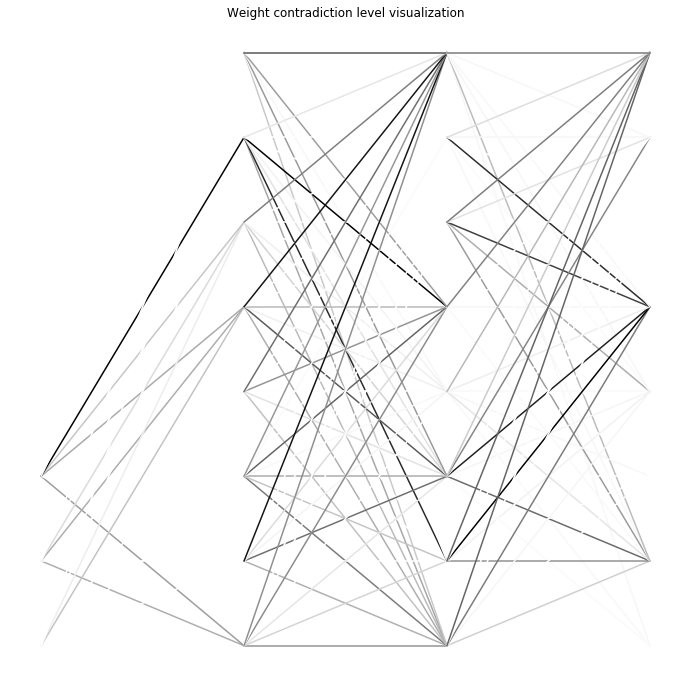

In [11]:
weight_contradict(pos_grad_dict, neg_grad_dict, method='sign')
weight_contradict(pos_grad_dict, neg_grad_dict, method='level')

### Get layer contradiction level

In [12]:
# avg/max of weight contradiction level for each layer
for name, grad_pos in pos_grad_dict.items():
    if 'weight' in name and 'conv' in name:
        grad_neg = neg_grad_dict[name]

        conflict_level = (torch.sign(grad_pos) != torch.sign(grad_neg)) * (torch.abs(grad_pos - grad_neg))
        
        conflict_level = conflict_level.sum(dim=(2, 3)) # sum over kernel size

        layer_conflict_level = conflict_level.mean().item()
        print(name, layer_conflict_level)

body.cnn1.conv.weight 0.4199502468109131
body.cnn2.conv.weight 0.33810287714004517
body.cnn3.conv.weight 0.25131669640541077


In [13]:
# avg/max of weight contradiction level for each layer
for name, grad_pos in pos_grad_dict.items():
    if 'weight' in name and 'conv' in name:
        grad_neg = neg_grad_dict[name]

        conflict_level = (torch.sign(grad_pos) != torch.sign(grad_neg)) * (torch.abs(grad_pos - grad_neg))
        
        conflict_level = conflict_level.sum(dim=(2, 3)) # sum over kernel size

        layer_conflict_level = conflict_level.max().item()
        print(name, layer_conflict_level)

body.cnn1.conv.weight 3.326033592224121
body.cnn2.conv.weight 1.5020121335983276
body.cnn3.conv.weight 1.4940218925476074


## Add one Conv filter

### Add to CNN1

In [5]:
model_name = 'CIFAR17_add110'
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

In [6]:
plot_training_acc( model, train_data_loader,
                   model_name=model_name, data_name='CIFAR10', total_trails=5)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### Add to CNN2

In [5]:
model_name = 'CIFAR17_add010'
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)


In [6]:
plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  0%|          | 0/1563 [00:03<?, ?it/s]


RuntimeError: cuda runtime error (30) : unknown error at /opt/conda/conda-bld/pytorch_1587428111115/work/aten/src/THC/THCGeneral.cpp:47

### Add to CNN3

  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.6869, Accuracy: 37824/50000 (76%)

Trail 2


  1%|          | 8/1563 [00:00<00:21, 73.51it/s]

Test set: Average loss: 0.7220, Accuracy: 37337/50000 (75%)

Trail 3


  0%|          | 7/1563 [00:00<00:22, 68.85it/s]

Test set: Average loss: 0.7064, Accuracy: 37396/50000 (75%)

Trail 4


100%|██████████| 1563/1563 [00:16<00:00, 97.66it/s] 


Test set: Average loss: 0.6950, Accuracy: 37796/50000 (76%)



  1%|          | 9/1563 [00:00<00:19, 80.49it/s]

Trail 5


100%|██████████| 1563/1563 [00:21<00:00, 74.19it/s]


Test set: Average loss: 0.6922, Accuracy: 37767/50000 (76%)



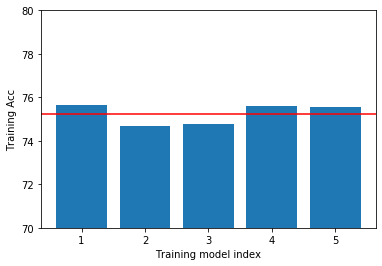

Average training acc: 75.248


[75.648, 74.674, 74.792, 75.592, 75.534]

In [14]:
model_name = 'CIFAR17_add001'
# initialize model
model = KNOWN_MODELS[model_name]
model = model.to(device)

plot_training_acc(model, train_data_loader,
                  model_name=model_name, data_name='CIFAR10', total_trails=5)

## Double the number of Conv filters

### Add to CNN1

  1%|          | 10/1563 [00:00<00:15, 99.50it/s]

Trail 1


  1%|          | 12/1563 [00:00<00:13, 117.43it/s]

Test set: Average loss: 0.6724, Accuracy: 38013/50000 (76%)

Trail 2


100%|██████████| 1563/1563 [00:13<00:00, 111.84it/s]


Test set: Average loss: 0.6838, Accuracy: 37928/50000 (76%)



  1%|          | 11/1563 [00:00<00:15, 102.48it/s]

Trail 3


100%|██████████| 1563/1563 [00:11<00:00, 138.33it/s]


Test set: Average loss: 0.6798, Accuracy: 37999/50000 (76%)



  1%|          | 16/1563 [00:00<00:10, 152.79it/s]

Trail 4


  1%|          | 12/1563 [00:00<00:13, 116.80it/s]

Test set: Average loss: 0.6695, Accuracy: 38084/50000 (76%)

Trail 5


100%|██████████| 1563/1563 [00:12<00:00, 124.36it/s]


Test set: Average loss: 0.6560, Accuracy: 38330/50000 (77%)



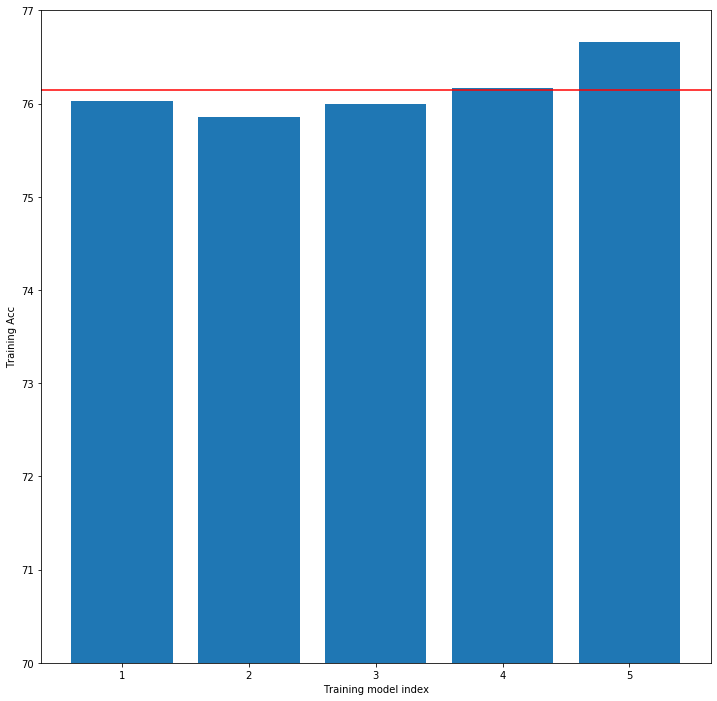

Average training acc: 76.1416


[76.026, 75.856, 75.998, 76.168, 76.66]

In [19]:
model_name = 'CIFAR17_double1'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN2

  1%|          | 11/1563 [00:00<00:15, 101.81it/s]

Trail 1


100%|██████████| 1563/1563 [00:12<00:00, 127.95it/s]


Test set: Average loss: 0.6700, Accuracy: 38133/50000 (76%)



  1%|          | 11/1563 [00:00<00:14, 109.59it/s]

Trail 2


  1%|          | 12/1563 [00:00<00:13, 115.55it/s]

Test set: Average loss: 0.6744, Accuracy: 38116/50000 (76%)

Trail 3


100%|██████████| 1563/1563 [00:12<00:00, 124.23it/s]


Test set: Average loss: 0.6689, Accuracy: 38182/50000 (76%)



  1%|          | 11/1563 [00:00<00:14, 106.75it/s]

Trail 4


100%|██████████| 1563/1563 [00:12<00:00, 128.54it/s]


Test set: Average loss: 0.6599, Accuracy: 38393/50000 (77%)



  1%|          | 11/1563 [00:00<00:14, 105.19it/s]

Trail 5


100%|██████████| 1563/1563 [00:11<00:00, 140.81it/s]


Test set: Average loss: 0.6662, Accuracy: 38159/50000 (76%)



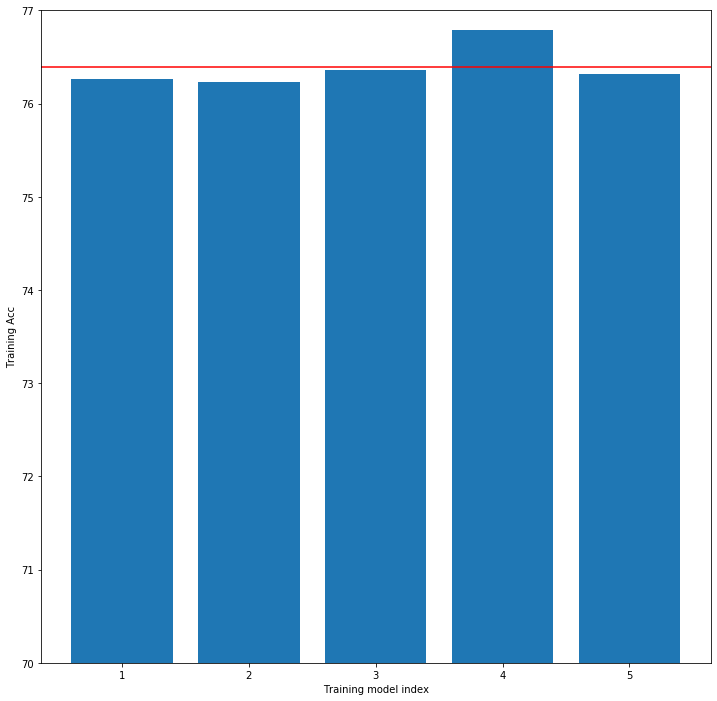

Average training acc: 76.39320000000001


[76.266, 76.232, 76.364, 76.786, 76.318]

In [20]:
model_name = 'CIFAR17_double2'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN3

  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.6476, Accuracy: 38518/50000 (77%)

Trail 2


  1%|          | 12/1563 [00:00<00:13, 114.83it/s]

Test set: Average loss: 0.6163, Accuracy: 39054/50000 (78%)

Trail 3


  1%|          | 11/1563 [00:00<00:14, 109.65it/s]

Test set: Average loss: 0.6079, Accuracy: 39172/50000 (78%)

Trail 4


  1%|          | 9/1563 [00:00<00:18, 82.94it/s]

Test set: Average loss: 0.6350, Accuracy: 38701/50000 (77%)

Trail 5


100%|██████████| 1563/1563 [00:15<00:00, 98.79it/s] 


Test set: Average loss: 0.6217, Accuracy: 38862/50000 (78%)



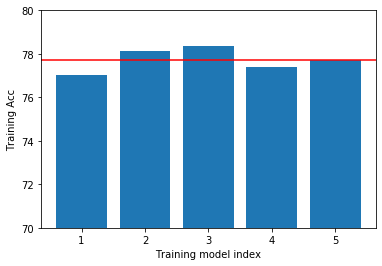

Average training acc: 77.72279999999999


[77.036, 78.108, 78.344, 77.402, 77.724]

In [6]:
model_name = 'CIFAR17_double3'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

## Increase Conv filter kernel size 

### Add to CNN1

  0%|          | 7/1563 [00:00<00:22, 69.86it/s]

Trail 1


100%|██████████| 1563/1563 [00:17<00:00, 87.57it/s] 


Test set: Average loss: 0.7452, Accuracy: 36855/50000 (74%)



  1%|          | 8/1563 [00:00<00:19, 78.77it/s]

Trail 2


100%|██████████| 1563/1563 [00:14<00:00, 106.99it/s]


Test set: Average loss: 0.7297, Accuracy: 37152/50000 (74%)



  1%|          | 9/1563 [00:00<00:18, 81.89it/s]

Trail 3


100%|██████████| 1563/1563 [00:15<00:00, 98.55it/s] 


Test set: Average loss: 0.7137, Accuracy: 37477/50000 (75%)



  1%|          | 9/1563 [00:00<00:18, 85.49it/s]

Trail 4


100%|██████████| 1563/1563 [00:15<00:00, 101.12it/s]


Test set: Average loss: 0.7053, Accuracy: 37584/50000 (75%)



  1%|          | 9/1563 [00:00<00:19, 79.68it/s]

Trail 5


100%|██████████| 1563/1563 [00:16<00:00, 95.06it/s] 


Test set: Average loss: 0.7346, Accuracy: 37182/50000 (74%)



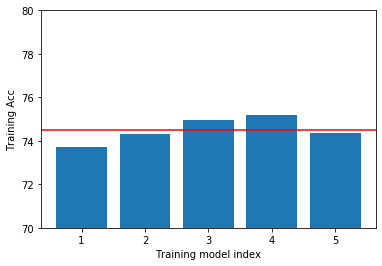

Average training acc: 74.5


[73.71, 74.304, 74.954, 75.168, 74.364]

In [7]:
model_name = 'CIFAR17_filter1'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN2

  0%|          | 0/1563 [00:00<?, ?it/s]

Trail 1


  1%|          | 8/1563 [00:00<00:20, 77.40it/s]

Test set: Average loss: 0.6973, Accuracy: 37666/50000 (75%)

Trail 2


100%|██████████| 1563/1563 [00:14<00:00, 111.31it/s]


Test set: Average loss: 0.7096, Accuracy: 37575/50000 (75%)



  1%|          | 9/1563 [00:00<00:19, 80.13it/s]

Trail 3


100%|██████████| 1563/1563 [00:16<00:00, 96.85it/s] 


Test set: Average loss: 0.7072, Accuracy: 37488/50000 (75%)



  1%|          | 9/1563 [00:00<00:18, 84.23it/s]

Trail 4


  0%|          | 5/1563 [00:00<00:39, 39.60it/s]

Test set: Average loss: 0.7321, Accuracy: 36913/50000 (74%)

Trail 5


100%|██████████| 1563/1563 [00:11<00:00, 132.37it/s]


Test set: Average loss: 0.7144, Accuracy: 37320/50000 (75%)



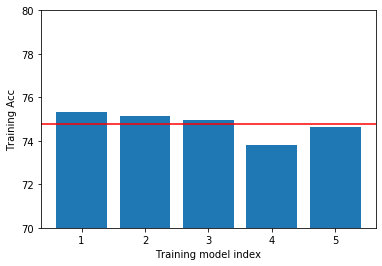

Average training acc: 74.78479999999999


[75.332, 75.15, 74.976, 73.826, 74.64]

In [8]:
model_name = 'CIFAR17_filter2'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)

### Add to CNN3

  0%|          | 3/1563 [00:00<01:04, 24.31it/s]

Trail 1


100%|██████████| 1563/1563 [00:16<00:00, 97.08it/s] 


Test set: Average loss: 0.7022, Accuracy: 37538/50000 (75%)



  1%|          | 9/1563 [00:00<00:19, 81.39it/s]

Trail 2


100%|██████████| 1563/1563 [00:15<00:00, 101.36it/s]


Test set: Average loss: 0.7183, Accuracy: 37351/50000 (75%)



  1%|          | 8/1563 [00:00<00:21, 71.93it/s]

Trail 3


  1%|          | 9/1563 [00:00<00:18, 84.80it/s]

Test set: Average loss: 0.6819, Accuracy: 37926/50000 (76%)

Trail 4


100%|██████████| 1563/1563 [00:14<00:00, 104.41it/s]


Test set: Average loss: 0.6921, Accuracy: 37707/50000 (75%)



  1%|          | 9/1563 [00:00<00:18, 82.78it/s]

Trail 5


100%|██████████| 1563/1563 [00:17<00:00, 89.88it/s] 


Test set: Average loss: 0.6793, Accuracy: 37976/50000 (76%)



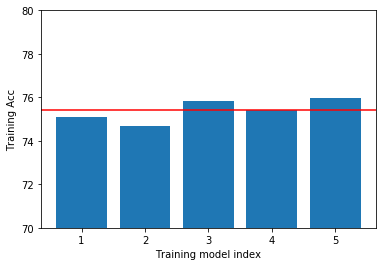

Average training acc: 75.3992


[75.076, 74.702, 75.852, 75.414, 75.952]

In [9]:
model_name = 'CIFAR17_filter3'
# initialize model
model = KNOWN_MODELS[model_name]()
model = model.to(device)

plot_training_acc( model, train_data_loader,
                      model_name=model_name, data_name='CIFAR10', total_trails=5)